In [5]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 18
})

In [2]:
# Create QPSK Symbols
num_symbols = 1000

x_int = np.random.randint(0, 4, num_symbols)
x_degrees = x_int*360/4.0 + 45
x_radians = x_degrees*np.pi/180.0
x_symbols = np.cos(x_radians) + 1j*np.sin(x_radians) 

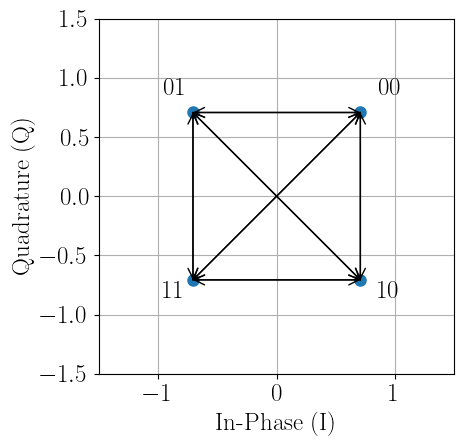

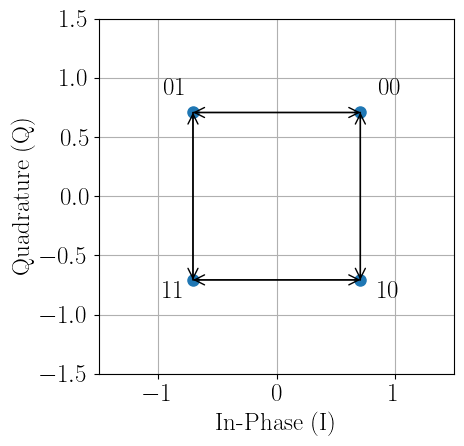

In [ ]:
plt.rcParams.update({"font.size": 18})
labels = ["00", "01", "11", "10"]
angles_deg = np.array([45, 135, 225, 315], dtype=float)
angles_rad = np.deg2rad(angles_deg)
points = np.cos(angles_rad) + 1j*np.sin(angles_rad)  # 4 QPSK-Symbole

offsets = {
    "00": (0.15, 0.15),   # rechts oben
    "01": (-0.25, 0.15),  # links oben
    "11": (-0.25, -0.15), # links unten
    "10": (0.15, -0.15),  # rechts unten
}

def draw_arrows(ax, src_points, dst_points, curved=False):
    for z0 in src_points:
        for z1 in dst_points:
            if z0 == z1:
                continue
            ax.annotate(
                "",
                xy=(np.real(z1), np.imag(z1)),
                xytext=(np.real(z0), np.imag(z0)),
                arrowprops=dict(arrowstyle="->", shrinkA=0, shrinkB=0, lw=1),
            )

# QPSK 
fig1, ax1 = plt.subplots()
ax1.plot(np.real(points), np.imag(points), "o", markersize=8)
ax1.set_aspect("equal", "box")
ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)
ax1.set_xlabel("In-Phase (I)")
ax1.set_ylabel("Quadrature (Q)")
draw_arrows(ax1, points, points)
for lab, z in zip(labels, points):
    dx, dy = offsets[lab]
    ax1.annotate(lab, (np.real(z)+dx, np.imag(z)+dy))
ax1.grid()
fig1.tight_layout()
plt.savefig("plots/qpsk.pdf", bbox_inches="tight")

# OQPSK
fig2, ax2 = plt.subplots()
ax2.plot(np.real(points), np.imag(points), "o", markersize=8)
ax2.set_aspect("equal", "box")
ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.5, 1.5)
ax2.set_xlabel("In-Phase (I)")
ax2.set_ylabel("Quadrature (Q)")
src = list(range(4))
neighbors = {i: [(i+1) % 4, (i-1) % 4] for i in src}
for i in src:
    for j in neighbors[i]:
        ax2.annotate(
            "",
            xy=(np.real(points[j]), np.imag(points[j])),
            xytext=(np.real(points[i]), np.imag(points[i])),
            arrowprops=dict(arrowstyle="->", shrinkA=0, shrinkB=0, lw=1),
        )
for lab, z in zip(labels, points):
    dx, dy = offsets[lab]
    ax2.annotate(lab, (np.real(z)+dx, np.imag(z)+dy))
ax2.grid()
fig2.tight_layout()
plt.savefig("plots/oqpsk.pdf", bbox_inches="tight")

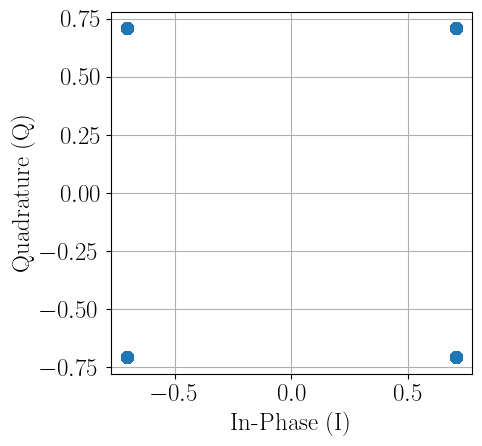

In [3]:
# Create OQPSK Symbols
rng = np.random.default_rng(7)

I_bits = 2*rng.integers(0, 2, num_symbols) - 1
Q_bits = 2*rng.integers(0, 2, num_symbols) - 1

I = np.repeat(I_bits, 2).astype(float)
Q = np.repeat(Q_bits, 2).astype(float)

Q_stag = np.roll(Q, 1)
Q_stag[0] = Q_stag[1]      

s = (I + 1j*Q_stag)/np.sqrt(2)

plt.figure()
plt.plot(np.real(s), np.imag(s), "o", markersize=8)
plt.xlabel("In-Phase (I)")
plt.ylabel("Quadrature (Q)")
plt.gca().set_aspect("equal")
plt.grid()
plt.tight_layout()
plt.show()

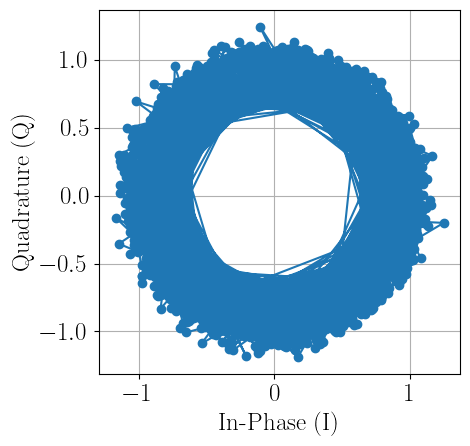

In [17]:
# Frequency-/Phaseoffset
f_off = 0.01
theta0 = np.deg2rad(10)
n = np.arange(len(s))
rotation = np.exp(1j*(2*np.pi*(f_off/2)*n + theta0))
r = s * rotation

snr_db = 20.0
snr = 10**(snr_db/10)
noise = (rng.standard_normal(len(s)) + 1j*rng.standard_normal(len(s))) / np.sqrt(2*snr)
r_noisy = r + noise

plt.plot(np.real(r_noisy), np.imag(r_noisy), "-o")
plt.xlabel("In-Phase (I)")
plt.ylabel("Quadrature (Q)")
plt.gca().set_aspect("equal")
plt.grid()
plt.tight_layout()
plt.show()

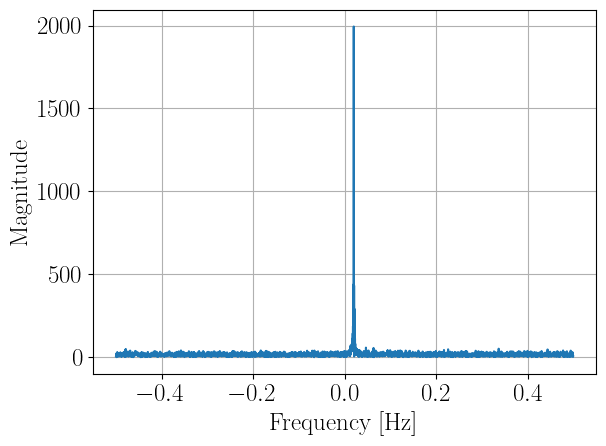

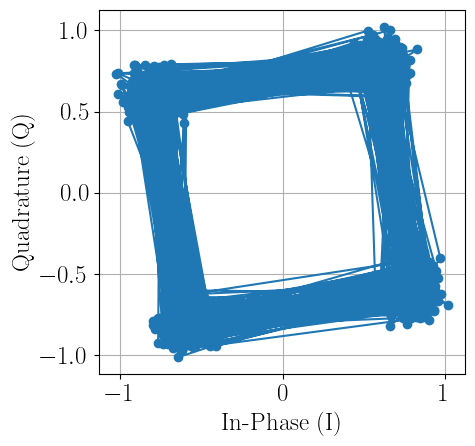

In [18]:
# CFO-correction
r_noisy_4 = r_noisy ** 4
R = np.fft.fftshift(np.fft.fft(r_noisy_4, 4096))
freqs = np.fft.fftshift(np.fft.fftfreq(len(R), d=1.0))
f_est_4x = freqs[np.argmax(np.abs(R))]
f_est = f_est_4x / 4.0

n = np.arange(len(r_noisy))
r_cfo = r_noisy * np.exp(-1j * 2*np.pi * f_est * n)

plt.figure()
plt.plot(freqs, np.abs(R))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(np.real(r_cfo), np.imag(r_cfo), "-o")
plt.xlabel("In-Phase (I)")
plt.ylabel("Quadrature (Q)")
plt.gca().set_aspect("equal")
plt.grid()
plt.tight_layout()
plt.show()

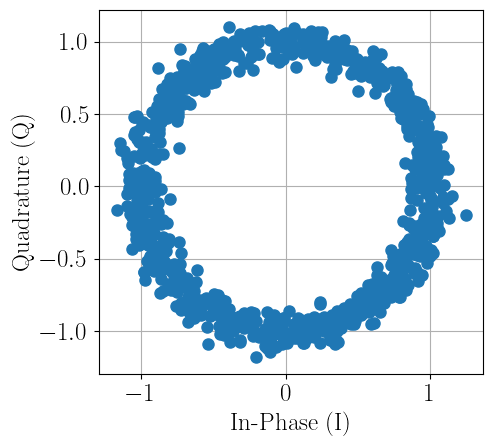

In [ ]:
mu = 0 # initial estimate of phase of sample
out = np.zeros(len(r_cfo) + 10, dtype=np.complex64)
out_rail = np.zeros(len(r_cfo) + 10, dtype=np.complex64) # stores values, each iteration we need the previous 2 values plus current value
i_in = 0 # input samples index
i_out = 2 # output index (let first two outputs be 0)
while i_out < len(r_cfo) and i_in+16 < len(r_cfo):
    out[i_out] = r_cfo[i_in] # grab what we think is the "best" sample
    out_rail[i_out] = int(np.real(out[i_out]) > 0) + 1j*int(np.imag(out[i_out]) > 0)
    x = (out_rail[i_out] - out_rail[i_out-2]) * np.conj(out[i_out-1])
    y = (out[i_out] - out[i_out-2]) * np.conj(out_rail[i_out-1])
    mm_val = np.real(y - x)
    mu += 2 + 0.3*mm_val
    i_in += int(np.floor(mu)) # round down to nearest int since we are using it as an index
    mu = mu - np.floor(mu) # remove the integer part of mu
    i_out += 1 # increment output index
r_sync = out[2:i_out] # remove the first two, and anything after i_out (that was never filled out)

plt.figure()
plt.plot(np.real(r_sync), np.imag(r_sync), "o", markersize=8)
plt.xlabel("In-Phase (I)")
plt.ylabel("Quadrature (Q)")
plt.gca().set_aspect("equal")
plt.grid()
plt.tight_layout()
plt.show()


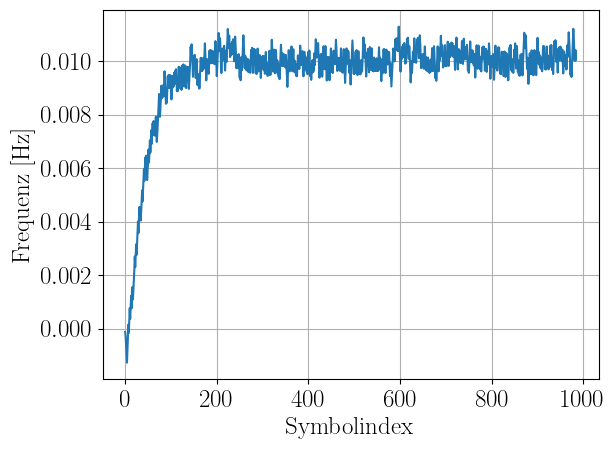

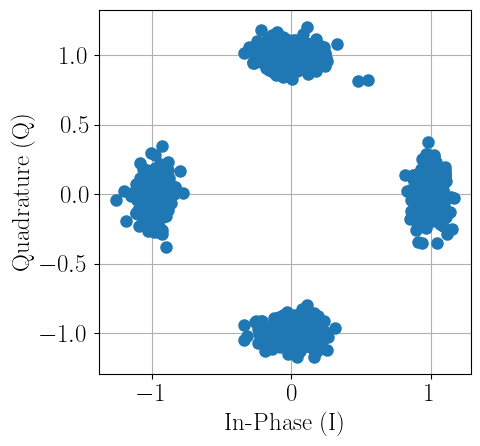

In [23]:
N = len(r_sync)             # r_sync: 1 sps, OQPSK bereits de-staggert -> QPSK-äquivalent
phase = 0.0                 # \theta_hat
freq  = 0.0                 # \omega_hat (rad/sample)

# Loop-Gains (2. Ordnung, moderat starten)
alpha = 0.12                # ≈ Kp
beta  = 0.003               # ≈ Ki

out = np.zeros(N, dtype=np.complex64)
freq_log = np.zeros(N)
err_log  = np.zeros(N)

for i in range(N):
    # derotate
    z = r_sync[i] * np.exp(-1j*phase)
    out[i] = z

    # QPSK-TED
    a = 1.0 if z.real >= 0 else -1.0
    b = 1.0 if z.imag >= 0 else -1.0
    error = z.real * b - z.imag * a
    err_log[i] = error

    # 2nd‑order loop update (PI)
    freq  += beta * error
    phase += freq + alpha * error

    # optional: Phase auf [-pi, pi) halten
    if phase >= np.pi:
        phase -= 2*np.pi
    elif phase < -np.pi:
        phase += 2*np.pi

    # nur fürs Loggen in "Hz", wenn du eine echte fs hast (sonst fs=1.0 lassen)
    fs = 1.0
    freq_log[i] = freq * fs / (2*np.pi)


plt.figure()
plt.plot(freq_log)
plt.xlabel("Symbolindex")
plt.ylabel("Frequenz [Hz]")
plt.grid()
plt.show()

plt.figure()
plt.plot(np.real(out), np.imag(out), "o", markersize=8)
plt.xlabel("In-Phase (I)")
plt.ylabel("Quadrature (Q)")
plt.gca().set_aspect("equal")
plt.grid()
plt.tight_layout()
plt.show()